# 体现神经网络思想的逻辑回归

接下来将构建一个逻辑回归分类器来判别是否是猫.这项任务将带领你学会如何借助神经思维来完成本项任务,同时也磨练你对深度学习的感觉.

**说明**:
- 不要在代码中出现循环(while/for),除非说明中明确要求你这样做.

**通过本次练习你将**:
- 建立一个学习算法的一般架构,包括:
    - 初始化参数
    - 计算其cost(成本)函数和梯度
    - 使用一种优化算法(梯度下降)
- 将函数按照正确的执行顺序,封装成为一个总的模型函数    

## 1 - 包 ##

在开始我们的任务之前开始运行下方的一个单元,里面包含我们即将用到的一些包:
- [numpy](www.numpy.org) Python科学计算中最最基础和重要的包.
- [h5py](http://www.h5py.org) 一个用于和存储在h5文件中的数据集交互的包
- [matplotlib](http://matplotlib.org) 一个著名的使用Python来绘图的包
- [PIL](http://www.pythonware.com/products/pil/) 以及 [scipy](https://www.scipy.org/) 在这里我们用他们来测试自己的模型.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

## 2 - 问题概况 ##

**问题表述**:给定一个数据集("data.h5"),其包含:
    - 一个训练集,大小为m_train,标记为: 是猫(y=1),不是猫(y=0)
    - 一个测试集,大小为m_test,标记为: 是猫(y=1),不是猫(y=0)
    - 每一张图像的大小(shape)为(num_px, num_px, 3),其中3代表图像的三个通道.可以看出这里的图像为正方形,高度height=num_px, 宽度height=num_px.

我们将编写一个最简单的图像识别算法,来准确判别一张图像是猫,抑或不是猫.

为了对于数据集更加熟悉,首先试着编写代码来加载我们的图像.

In [2]:
# 加载数据 (是猫/非猫)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

我们在部分数据集(训练集还有测试集)变量之后增加"_orig",因为我们需要预处理他们.经过预处理,变量将以"train_set_x","test_set_x"重新示人("train_set_y","test_set_y"不需要任何预处理操作).

"train_set_x_orig" 和 "test_set_x_orig"的每一行表示一张图象.运行下方代买来展示数据,改变索引值重新运行来查看其他图像.

y= [1], it's a 'cat' picture.


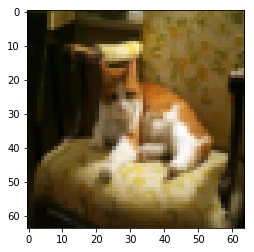

In [25]:
# print("Train pictures: ",len(train_set_x_orig))
# print("Test pictures: ",len(test_set_x_orig))

# 图像示例
index = 7
plt.imshow(train_set_x_orig[index])
print("y= "+str(train_set_y[:, index]) +", it's a '"+classes[np.squeeze(train_set_y[:, index])].decode("utf-8")+"' picture.")

在深度学习中许多软件上的错误是在运算是矩阵或者向量的维度数不匹配造成的.如果你在整个过程中严格控制参与计算的矩阵和向量的维度,就能够消除相当一部分bugs.

**练习**:弄清下面的几个关键指标:
    - m_train : 训练集的个数
    - m_test : 测试集的个数
    - num_px : 对于测试集来说,等于图像的高度和宽度
`train_set_x_orig` 类型是大小为 (m_train, num_px, num_px, 3)的numpy array类型.因此,你可以编写如`train_set_x_orig.shape[0]`来获取`m_train`.

In [27]:
### 代码开始 ### (≈ 3 行代码)
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
### 代码结束 ###

print ("训练样本的个数: m_train = " + str(m_train))
print ("测试样本的个数: m_test = " + str(m_test))
print ("每张图像的高度/宽度: num_px = " + str(num_px))
print ("每张图像的大小: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x 形状: " + str(train_set_x_orig.shape))
print ("train_set_y 形状: " + str(train_set_y.shape))
print ("test_set_x 形状: " + str(test_set_x_orig.shape))
print ("test_set_y 形状: " + str(test_set_y.shape))

训练样本的个数: m_train = 209
测试样本的个数: m_test = 50
每张图像的高度/宽度: num_px = 64
每张图像的大小: (64, 64, 3)
train_set_x 形状: (209, 64, 64, 3)
train_set_y 形状: (1, 209)
test_set_x 形状: (50, 64, 64, 3)
test_set_y 形状: (1, 50)


**Expected Output for m_train, m_test and num_px**: 
<table style="width:15%">
  <tr>
    <td>**m_train**</td>
    <td> 209 </td> 
  </tr>
  
  <tr>
    <td>**m_test**</td>
    <td> 50 </td> 
  </tr>
  
  <tr>
    <td>**num_px**</td>
    <td> 64 </td> 
  </tr>
  
</table>


方便起见,你现在应当重塑图像的形状(shape),有原来的(num_px, num_px, 3)重塑为(num_px*num_px*3, 1)的numpy array.经过处理,我们的训练(测试)集就是一个numpy array,其中每一列代表这一张展开的图片.而总共有m_train列(对测试集而言有m_test).

**练习**:对训练集和测试集图像进行重塑,使得每张图像从原来的(num_px, num_px, 3)展开为(num_px*num_px*3, 1)的向量.

当你想将一个形状为(a, b, c, d)的矩阵 X 重塑为形状为(b*c*d, a)的矩阵 X_flatten,可以这样:
```python
    X_flatten = X.reshape(X.shape[0], -1).T # X.T 表示求X的转置
```

In [31]:
# 重塑训练和测试样本

### 代码开始 ### (≈ 2 行代码)
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
### 代码结束 ###

print ("train_set_x_flatten 形状: " + str(train_set_x_flatten.shape))
print ("train_set_y 形状: " + str(train_set_y.shape))
print ("test_set_x_flatten 形状: " + str(test_set_x_flatten.shape))
print ("test_set_y 形状: " + str(test_set_y.shape))
print ("重塑后安全检测: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten 形状: (12288, 209)
train_set_y 形状: (1, 209)
test_set_x_flatten 形状: (12288, 50)
test_set_y 形状: (1, 50)
重塑后安全检测: [17 31 56 22 33]


**期望输出**: 

<table style="width:35%">
  <tr>
    <td>**train_set_x_flatten shape**</td>
    <td> (12288, 209)</td> 
  </tr>
  <tr>
    <td>**train_set_y shape**</td>
    <td>(1, 209)</td> 
  </tr>
  <tr>
    <td>**test_set_x_flatten shape**</td>
    <td>(12288, 50)</td> 
  </tr>
  <tr>
    <td>**test_set_y shape**</td>
    <td>(1, 50)</td> 
  </tr>
  <tr>
  <td>**sanity check after reshaping**</td>
  <td>[17 31 56 22 33]</td> 
  </tr>
</table>

为了表示一张彩色图像，对于其中的每个像素都要规定其红色(red)，绿色(green)，蓝色(blue)(RGB)通道.所以,实际上每个像素都是一个三维的向量,其中每一维数值范围在[0, 255]之间.

在机器学习中,一个很普遍的预处理步骤就是对数据集进行取中心(center, 动词)和标准化(standardize,动词).意思是,每个元素都要先减去整个数组(numpy array)的均值,人后除以整个数组(numpy array)的标准差.但是对于图像数据集而言,有更加简便的操纵,就是对数据集中的每一行除以255(一个像素通道中的最大值),也能得到比较好的效果.

下面开始标准化我们的数据集.

In [32]:
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255

<font color='blue'>
**请牢记:**

预处理一个新的数据集的常见步骤:
- 弄清楚问题的维度数和形状 (m_train, m_test, num_px, ...)
- 重塑数据集,例如处理成每个样例为一个向量 (num_px \* num_px \* 3, 1)
- "标准化"数据

## 3 - 学习算法的一般结构 ##

现在是时候设计一个能从喵咪和非喵咪图像中把猫简易区分出来了的算法了.

下面开始动手实现一个线性回归,其蕴含了神经网络的思想.下图解释了**为什么说线性回归是一种简单的神经网络!**

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**线性回归算法的数学表达式**:
对于一个输入样例(图像) $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

将所有训练集的计算结果相加,求平均值可以得到总的成本(cost):
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**关键步骤**:在此练习中,你应当进行下面几个步骤:
    - 对模型中的参数进行初始化
    - 通过最小化成本(cost)来学习参数
    - (在测试集上)使用训练好的参数来进行预测
    - 分析结果并得出结论

## 4 - 构建我们算法中的部分 ##

构建一个神经网络的主要步骤如下:
1. 定义模型的结构(例如输入特征的个数)
2. 初始化模型的参数
3. 循环:
    - 计算当前层损失(前向传播)
    - 计算当前层梯度(后向传播)
    - 更新参数(梯度下降)

1-3 步骤可以分开编写,最后将其整合到一个函数中,起名比如叫做`model()`.

### 4.1 - 辅助函数

**练习**:从之前的`Python numpy基础`中,实现`sigmoid()`.从上面的原理图可以看出,你需要计算$sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ 来进行预测.其中会使用到np.exp().

In [33]:
# 函数: sigmoid

def sigmoid(z):
    """
    计算输入 z 的sigmoid值

    参数:
    z -- 一个标量或者任意大小的numpy array.

    返回:
    s -- sigmoid(z)
    """

    ### 代码开始 ### (≈ 1 行代码)
    s = 1/(1+np.exp(-z))
    ### 代码结束 ###
    
    return s

In [34]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [ 0.5         0.88079708]


**期望输出**: 

<table>
  <tr>
    <td>**sigmoid([0, 2])**</td>
    <td> [ 0.5         0.88079708]</td> 
  </tr>
</table>

### 4.2 初始化参数

**练习**:实现参数的初始化.你可以将权重参数初始化零向量.(一般初学者才会这样做).如果你不知道应该用numpy中的什么函数,可以去numpy的官方文档中查找`np.zeros()`的用法.

In [35]:
# 函数: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    本函数用来窗机一个零向量 w,shape为(dim, 1), b 初始化为0
    
    参数:
    dim -- w (权重) 向量的大小 (或者本例中表示参数的个数)
    
    返回:
    w -- 初始化后的向量,大小为 (dim, 1)
    b -- 初始化后的标量(和偏差对应)
    """
    
    ### 代码开始 ### (≈ 1行代码)
    w = np.zeros((dim, 1))
    b = 0
    ### 代码结束 ###
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [36]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[ 0.]
 [ 0.]]
b = 0


**期望输出**: 


<table style="width:15%">
    <tr>
        <td>  ** w **  </td>
        <td> [[ 0.]
 [ 0.]] </td>
    </tr>
    <tr>
        <td>  ** b **  </td>
        <td> 0 </td>
    </tr>
</table>

For image inputs, w will be of shape (num_px $\times$ num_px $\times$ 3, 1).

### 4.3 - 前向传播和反向传播 

参数初始化完毕,接下来可以使用"前向传播"和"反向传播"来更新你的参数.

**练习**:实现函数 `propagate()` 来计算 cost 和梯度.

**提示**:
前向传播:
- 给定X
- 计算出 $A = \sigma (w^T X+ b)=(a^{(0)}, a^{(1)},..., a^{(m-1)}, a^{(m)})$
- 计算 cost 函数: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

你将会用到一下两个方程式:

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [37]:
# 函数: propagate
import math

def propagate(w, b, X, Y):
    """
    实现上述的成本(cost)函数以及其梯度计算

    参数:
    w -- 权重,shape 为 (num_px * num_px * 3, 1)的numpy array
    b -- 偏差, 一个标量
    X -- 数据的大小 (num_px * num_px * 3, 例子的个数)
    Y -- 真实的标记向量 ( 0 代表非猫, 1 代表是猫) 大小为 (1, number of examples)

    返回:
    cost -- 逻辑回归的负对数似然成本(cost)
    dw -- w 的损失的梯度, 因此和 w 的shape一致
    db -- b 的损失的梯度, 因此和 b 的shape一致
    
    小贴士:
    - 一步步地来写你的回归函数.会用到np.log(), np.dot()函数
    """
    
    m = X.shape[1]
    
    # 前向传播(从 X 到 COST)
    ### 代码开始 ### (≈ 2 行代码)
    Z=np.dot(np.transpose(w),X)+b
    A = sigmoid(Z)                                  # 计算激活值
    cost = -1*((np.sum((Y*np.log(A))+((1-Y)*(np.log(1-A))),axis=1))/m)                             # 计算 cost
    ### 代码结束 ###
    
    # 反向传播 (找到合适的梯度)
    ### 代码开始 ### (≈ 2 行代码)
    dw = np.dot(X, np.transpose(A-Y))/m
    db = np.sum((A-Y), axis=1)/m
    ### 代码结束 ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [38]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[ 0.99845601]
 [ 2.39507239]]
db = [ 0.00145558]
cost = 5.801545319394553


**期望输出**:

<table style="width:50%">
    <tr>
        <td>  ** dw **  </td>
      <td> [[ 0.99845601]
     [ 2.39507239]]</td>
    </tr>
    <tr>
        <td>  ** db **  </td>
        <td> 0.00145557813678 </td>
    </tr>
    <tr>
        <td>  ** cost **  </td>
        <td> 5.801545319394553 </td>
    </tr>

</table>

### d) 优化
- 你已经初始化了你的参数.
- 你也能够计算出一个cost 函数和其梯度.
- 现在,你想要使用梯度下降来更新你的参数.

**练习**:编写`optimize`函数.目标就是通过最小化cost 函数值$J$ 来学些$w$和$b$.对于一个参数$\theta$, 更新规则为 $ \theta = \theta - \alpha \text{ } d\theta$,其中的$\alpha$是学习率.

In [39]:
# 函数: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    通过梯度下降算法来优化 w 和 b.
    
    参数:
    w -- 权重,shape 为 (num_px * num_px * 3, 1)的numpy array
    b -- 偏差, 一个标量
    X -- 数据的大小 (num_px * num_px * 3, 例子的个数)
    Y -- 真实的标记向量 ( 0 代表非猫, 1 代表是猫) 大小为 (1, number of examples)
    num_iterations -- 优化过程中循环迭代的次数
    learning_rate -- 学习率,梯度下降算法参数更新的法则
    print_cost -- 为True的话,没一百次迭代打印一次loss值
    
    返回:
    params -- 一个字典,包含权重 w 和 偏差 b
    grads -- 一个字典,其中包含 cost 函数对于权重 w 和偏差 b 的梯度(导数)
    costs -- 一个列表,记录优化过程中计算得到的cost,用来绘制学习曲线
    
    小贴士:
    你总体上需要两个步骤,并不断迭代进行它们:
        1) 对于当前的参数,计算其 cost 和梯度.通过上面的propagate()函数.
        2) 式样梯度下降法来更新 w 和 b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost 和 梯度 计算 (≈ 1-4 行代码)
        ### 代码开始 ### 
        grads, cost =  propagate(w, b, X, Y)
        ### 代码结束 ###
        
        # 从传回参数中提取
        dw = grads["dw"]
        db = grads["db"]
        
        # 更新法则 (≈ 2 行代码)
        ### 代码卡死hi ###
        w = w-learning_rate*dw
        b = b-learning_rate*db
        ### 代码结束 ###
        
        # 记录 cost 值
        if i % 100 == 0:
            costs.append(cost)
        
        # 每100从迭代大打印出一次 cost
        if print_cost and i % 100 == 0:
            print ("经过 %i 次迭代的 Cost: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [40]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[ 0.19033591]
 [ 0.12259159]]
b = [ 1.92535983]
dw = [[ 0.67752042]
 [ 1.41625495]]
db = [ 0.2191945]


**期望输出**: 

<table style="width:40%">
    <tr>
       <td> **w** </td>
       <td>[[ 0.19033591]
 [ 0.12259159]] </td>
    </tr>
    
    <tr>
       <td> **b** </td>
       <td> 1.92535983008 </td>
    </tr>
    <tr>
       <td> **dw** </td>
       <td> [[ 0.67752042]
 [ 1.41625495]] </td>
    </tr>
    <tr>
       <td> **db** </td>
       <td> 0.219194504541 </td>
    </tr>

</table>

**练习:** 上面的函数会输出学习后的 w 和 b. 我们能够使用这训练到的参数 w 和 b 对于一个数据集 X 来进行预测.实现函数`predict()`.计算预测值遵循以下两步:

1. 计算 $\hat{Y} = A = \sigma(w^T X + b)$

2. 将A预测值转化为0 或者 1(比如经过激活函数后,值>0.5,认为其为1;值<0.5,认为其值为0),将预测值存储到向量`Y_prediction`中. 说明一点,如果有必要,可以在循环中使用`if/else`语句,当然也有与之等价的向量化的操作方法.

In [42]:
# 函数: predict

def predict(w, b, X):
    '''
    使用学习到的参数 (w, b) , 来得出预测,输出标签 0 或者 1
    
    参数:
    w -- 权重,shape 为 (num_px * num_px * 3, 1)的numpy array
    b -- 偏差, 一个标量
    X -- 数据的大小 (num_px * num_px * 3, 例子的个数)
    
    返回:
    Y_prediction -- 一个numpy array (向量),包含对于输入X的所有预测(0/1)
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # 计算向量 "A" 预测一张图片中判断是猫的概率
    ### 代码开始 ### (≈ 1 行代码)
    A = sigmoid(np.dot(w.T, X)+b)
    ### 代码结束 ###
    
    for i in range(A.shape[1]):

        # 将 A[0,i] 转换为 p[0,i]
        ### 代码开始 ### (≈ 4 行代码)
        if A[0][i]>0.5 :
            Y_prediction[0][i]=1
        else:
            Y_prediction[0][i]=0
        ### 代码结束 ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [43]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("预测 = " + str(predict(w, b, X)))

预测 = [[ 1.  1.  0.]]


**期望结果**: 

<table style="width:30%">
    <tr>
         <td>
             **预测**
         </td>
          <td>
            [[ 1.  1.  0.]]
         </td>  
   </tr>

</table>


<font color='blue'>
**请牢记:**
你已经实现了上述几个函数:
- 初始化 (w,b)
- 通过训话迭代学习(w,b)来优化损失(loss):
    - 计算cost 和其梯度
    - 使用梯度下降来更新参数
- 使用学到的 (w,b) 来对于一个给定的样例集预测标签

### 5 - 将所有函数整合成一个模型 ##

现在，您将看到整个模型是如何构建的: 将所有构建模块（前面部分中实现的功能）以正确的顺序放在一起。

**练习**:实现 model 函数,请遵守以下符号约定:
    - Y_prediction: 在测试集上运行的结果
    - Y_prediction_train: 在训练集上的预测结果
    - w, costs, grads 接受经过optimize()处理后的返回值

In [54]:
# 函数: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    通过调用之前实现的函数,来构建逻辑回归的模型
    
    参数:
    X_train -- 训练集,表征为shape (num_px * num_px * 3, m_train)的numpy array
    Y_train -- 训练集标签, 表征为一个 numpy array (向量), shape为 (1, m_train)
    X_test -- 测试集, 表征为一个 numpy array, shape 为(num_px * num_px * 3, m_test)
    Y_test -- 训练集标签, 表征为一个 numpy array (向量), shape为 (1, m_test)
    num_iterations -- 超参数, 优化参数用来控制迭代次数
    learning_rate -- 超参数, optimize()函数更新参数规则中的学习率设置
    print_cost -- 为true,每100次迭代输出一次cost值
    
    返回:
    d -- 数据字典,包含此模型的所有关键信息.
    """
    
    ### 代码开始 ###
    
    # 初始化参数为0 (≈ 1 行代码)
    w, b = initialize_with_zeros(X_train.shape[0])
    
    # 梯度下降 (≈ 1 行代码)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    # 从字典"parameters"中提取参数 w 和 b
    w = parameters["w"]
    b = parameters["b"]
    
    # 对训练/测试集进行预测 (≈ 2 行代码)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b,X_train )

    ### 代码结束 ###

    # print((100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    # 输出训练误差和测试误差 Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [56]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.004, print_cost = True)

经过 0 次迭代的 Cost: 0.693147
经过 100 次迭代的 Cost: 0.506765
经过 200 次迭代的 Cost: 0.442269
经过 300 次迭代的 Cost: 0.397201
经过 400 次迭代的 Cost: 0.362439
经过 500 次迭代的 Cost: 0.334271
经过 600 次迭代的 Cost: 0.310725
经过 700 次迭代的 Cost: 0.290608
经过 800 次迭代的 Cost: 0.273138
经过 900 次迭代的 Cost: 0.257771
经过 1000 次迭代的 Cost: 0.244114
经过 1100 次迭代的 Cost: 0.231873
经过 1200 次迭代的 Cost: 0.220823
经过 1300 次迭代的 Cost: 0.210787
经过 1400 次迭代的 Cost: 0.201623
经过 1500 次迭代的 Cost: 0.193217
经过 1600 次迭代的 Cost: 0.185474
经过 1700 次迭代的 Cost: 0.178317
经过 1800 次迭代的 Cost: 0.171678
经过 1900 次迭代的 Cost: 0.165504
train accuracy: 98.08612440191388 %
test accuracy: 70.0 %


**期望输出**: 

<table style="width:40%"> 

    <tr>
        <td> **Cost after iteration 0 **  </td> 
        <td> 0.693147 </td>
    </tr>
      <tr>
        <td> <center> $\vdots$ </center> </td> 
        <td> <center> $\vdots$ </center> </td> 
    </tr>  
    <tr>
        <td> **Train Accuracy**  </td> 
        <td> 99.04306220095694 % </td>
    </tr>

    <tr>
        <td>**Test Accuracy** </td> 
        <td> 70.0 % </td>
    </tr>
</table> 

**注释**: 训练准确度已经接近100%,说明模型对于训练集数据有很好的拟合.测试误差为70%左右.对于这个简单模型而言已经足够好,毕竟我们目前使用的还是线性分类器.在之后的学习中,我们会使用更好的分类器.

并且我们很明显就能看出,模型对于测试数据有过拟合.之后我们还会学习一些防止过度拟合的方法,比如说正则化.运行下方代码,来看看模型在测试集上的预测结果和实际结果.

y = 1
预测值:  1.0


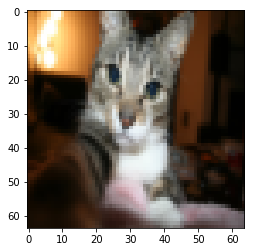

In [79]:
# 模型在测试集上的预测结果.
index = 25
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]))
print("预测值: ", d['Y_prediction_test'][0,index])

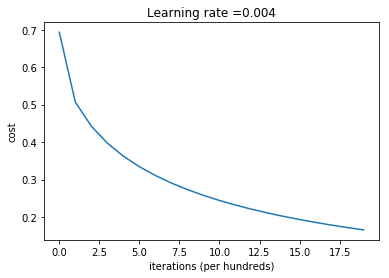

In [83]:
# 学习曲线图像 (带有cost值)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel(u'iterations (per hundreds)')
plt.title(u"Learning rate =" + str(d["learning_rate"]))
plt.show()

**解释**:你可以看到cost在下降.它表明参数正在被学习.但是，在训练集上进一步训练模型. 比如尝试增加上面单元格中的迭代次数，然后重新运行单元格. 您可能会看到训练集的准确度上升，但测试集准确度下降. 这被称为过度拟合.

## 6 - 进一步分析 ##

恭喜你成功搭建一的第一个图像分类模型.让我们进一步分析,检查调整学习率$\alpha$.

#### 学习率的选择 ####

**回顾**:
为了是梯度下降运行的结果更好,你必须明智地选择学习率.学习率$\alpha$决定着我们更新参数的速率.如果学习率太高，我们可能会"错过"最优值.同样，如果它太小，我们将需要太多次迭代来收敛到最佳值.这就是为什么选择一个合适的学习率至关重要的原因.

让我们选取几个学习率运行模型,绘制其学习曲线并比较.

学习率: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

学习率: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

学习率: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



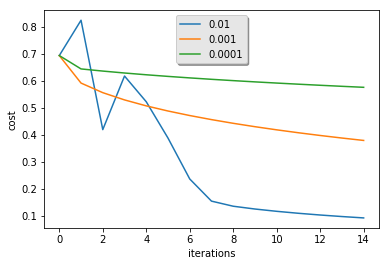

In [84]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("学习率: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

## 7 - 将自己的图片作为输入 ##

将自己的图片作为输入来测试你的模型.
1. 点击notebook上方工具条中的`File`,点击`open`
2. 进入本工程路径下,将自己的图片上传到`images`文件夹下
3. 将下方代码中文件名改为自己上传图片的名称
4. 运行下发代码,并检查算法运行的正确性(1: 是猫; 0:非猫)

y = 1.0, 模型预测是一张 "cat" 图像.


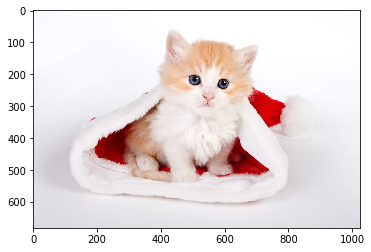

In [104]:
## 代码开始 ## (PUT YOUR IMAGE NAME) 
my_image = "my_image1.jpg"   # 将其改为你自己的图像文件名
## 代码结束 ##

# 预处理图像以适应于本模型
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", 模型预测是一张 \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" 图像.")

<font color='blue'>
**通过本任务**:
1. 预处理数据很重要
2. 分别实现函数:initialize(), propagate(), optimize().然后构建了一个模型 model()
3. 设置不同的学习率对于算法的效果影响至关重要.

一些有意义的尝试:
    - 试着改变学习率和迭代的次数
    - 尝试不同的初始化方法(随机初始化)来比较结果
    - 测试其他预处理方法(取数据中心,或则会每一行除以其标准差)

**参考**:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c